In [1]:
from datasets import load_dataset
import base64
import time
from openai import OpenAI

In [2]:
import json, time
from typing import Dict, Any, Tuple
from openai import OpenAI

In [3]:
import base64
from io import BytesIO
from PIL import Image  # pip install pillow
from IPython.display import display

In [4]:
# %load_ext cudf.pandas
import pandas as pd

In [5]:
# point to any judge server you started (Phi-4, InternVL2, or OneVision)
EVAL_MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"
JUDGE_MODEL= "google/gemma-3-27b-it"

# point to your vLLM server
eval_client = OpenAI(base_url="http://localhost:8000/v1", api_key="EMPTY")
judge_client = OpenAI(base_url="http://localhost:8002/v1", api_key="EMPTY")

### Load Dataset

In [6]:
dataset = load_dataset("lmarena-ai/VisionArena-Chat", split="train", streaming=True)
en_dataset = dataset.filter(lambda ex: ex["num_turns"] == 1 and ex["language"] == "English")

small_ds = en_dataset.take(100)
# To access the first conversation
small_ds, type(small_ds)

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

(IterableDataset({
     features: ['images', 'conversation_id', 'model', 'num_turns', 'conversation', 'language', 'user_id', 'tstamp', 'is_preset', 'preset_dataset', 'categories'],
     num_shards: 43
 }),
 datasets.iterable_dataset.IterableDataset)

In [7]:
it = iter(small_ds)
for idx, val in enumerate(it):
    print(idx, val['model'], 
        #   val['conversation'], 
          # print({k: v for k, v in val["categories"].items()})
    )

0 qwen2-vl-72b
1 gemini-1.5-pro-api-0514
2 gemini-1.5-flash-8b-exp-0924
3 gpt-4o-mini-2024-07-18
4 gemini-1.5-pro-api-0514
5 gemini-1.5-flash-api-0514
6 llava-onevision-qwen2-72b-ov-chat
7 gpt-4o-mini-2024-07-18
8 pixtral-12b-2409
9 gpt-4-turbo-2024-04-09
10 reka-flash-preview-20240611
11 gemini-1.5-pro-exp-0801
12 claude-3-5-sonnet-20240620
13 gemini-1.5-pro-exp-0801
14 gpt-4-turbo-2024-04-09
15 claude-3-5-sonnet-20240620
16 gemini-1.5-pro-002
17 llama-3.2-vision-11b-instruct
18 gemini-1.5-flash-8b-exp-0827
19 claude-3-5-sonnet-20240620
20 claude-3-opus-20240229
21 gemini-1.5-pro-api-0514
22 llava-v1.6-34b
23 claude-3-5-sonnet-20240620
24 gemini-1.5-pro-exp-0827
25 chatgpt-4o-latest-20240903
26 internvl2-4b
27 dumbledore-v1
28 gpt-4o-mini-2024-07-18
29 gemini-1.5-flash-api-0514
30 minicpm-v-2_6
31 pixtral-12b-2409
32 chatgpt-4o-latest-20240903
33 gemini-1.5-flash-exp-0827
34 chatgpt-4o-latest-20240903
35 phi-3.5-vision-instruct
36 gpt-4o-2024-05-13
37 gemini-1.5-pro-api-0514
38 claude

### Filtering per Category

In [8]:
from collections import defaultdict

def sample_by_category(
    it,
    category_key="categories",
    id_key=None,                 # if provided, used to dedupe (e.g., "conversation_id")
    target_categories=None,      # if provided, limit to these category names
    k=10,
    exclusive=False,
):
    """
    Returns dict: {category: [records]}
    - Non-exclusive: a record can appear in multiple category lists.
    - Exclusive: each record appears in at most one category (the 'neediest' bucket).
    """
    buckets = defaultdict(list)
    counts = defaultdict(int)
    used_ids = set()

    # Helper: do we already have k for all target cats?
    def all_filled():
        cats = target_categories or list(counts.keys())
        # If counts has not seen some target yet, treat as 0
        return all(counts.get(c, 0) >= k for c in cats)

    for rec in it:
        cats_dict = rec.get(category_key, {}) or {}
        cats = [c for c, v in cats_dict.items() if v]

        if not cats:
            continue

        if target_categories is not None:
            cats = [c for c in cats if c in target_categories]
            if not cats:
                continue

        rec_id = rec.get(id_key) if id_key else None
        if exclusive:
            # Skip if we already used this record
            if rec_id is not None and rec_id in used_ids:
                continue
            # Choose the category among this record's cats with the smallest fill so far
            neediest = None
            neediest_count = float("inf")
            for c in cats:
                if counts[c] < k and counts[c] < neediest_count:
                    neediest = c
                    neediest_count = counts[c]
            if neediest is not None:
                buckets[neediest].append(rec)
                counts[neediest] += 1
                if rec_id is not None:
                    used_ids.add(rec_id)
        else:
            # Add this record to every category that still needs items
            added_any = False
            for c in cats:
                if counts[c] < k:
                    buckets[c].append(rec)
                    counts[c] += 1
                    added_any = True
            # Optional: if you want to avoid the *same* record appearing
            # multiple times in the same category due to repeated iterator entries,
            # also track used_ids per-category. Skipped here since iterator
            # usually yields unique items.

        if all_filled():
            break

    return dict(buckets)
it = iter(small_ds)
cats = ["captioning","code","ocr","refusal"]
result = sample_by_category(it, target_categories=cats, k=10)

In [9]:
for k, v in result.items():
    print(k, len(v))

ocr 10
code 6
captioning 10
refusal 1


In [10]:
# (result['ocr'])[0][]
for k, v in result['ocr'][2].items():
    if k != "images":   # skip "b"
        print(k, v)

conversation_id 025dd275ecaf4b8bab1b1e9ca769164a
model gpt-4o-mini-2024-07-18
num_turns 1
conversation [[{'content': 'Refer to the figure. For Ben, what is the opportunity cost of 1 kg of ice cream?\nQuestion 50 options:\n\na) \n\n1/4 kg of cones\n\n\nb) \n\n1/2 kg of cones\n\n\nc) \n\n2 kg of cones\n\n\nd) \n\n4 kg of cones\n\n', 'role': 'user'}], [{'content': 'To find the opportunity cost of 1 kg of ice cream for Ben, we can analyze the production possibilities frontier (PPF) based on the graph provided.\n\nFrom the graph:\n- Ben can produce a maximum of 2 kg of ice cream and 8 cones. \n\nTo calculate the opportunity cost of 1 kg of ice cream:\n1. If Ben produces 0 kg of ice cream, he can produce 8 cones.\n2. If he produces 2 kg of ice cream, he produces 0 cones.\n\nThe trade-off shows that producing 2 kg of ice cream costs him 8 cones. Therefore, the opportunity cost of producing 1 kg of ice cream is:\n\n\\[\n\\text{Opportunity Cost} = \\frac{8 \\text{ cones}}{2 \\text{ kg of ice cr

### Testing one sample

In [11]:
it = iter(small_ds)
first = next(it)
first = next(it)
first = next(it)
first.keys()

dict_keys(['images', 'conversation_id', 'model', 'num_turns', 'conversation', 'language', 'user_id', 'tstamp', 'is_preset', 'preset_dataset', 'categories'])

In [12]:
list_of_columns_to_view = [ 'conversation_id', 'model', 'num_turns', 'conversation', 'language', 'user_id', 'tstamp', 'is_preset', 'preset_dataset', 'categories']

In [13]:
for k, v in first.items():
    if k != "images":   # skip "b"
        print(k, v)

conversation_id fa477bd697d8453182064a05a525ab59
model gemini-1.5-flash-8b-exp-0924
num_turns 1
conversation [[{'content': 'Please, convert these formulas to markdown LaTeX, use russian for text', 'role': 'user'}], [{'content': '```latex\nk_t = \\begin{cases}\n1, & \\text{если } y_t \\text{ больше всех предыдущих уровней}, \\\\\n0, & \\text{в противном случае},\n\\end{cases}\n```\n\n```latex\nl_t = \\begin{cases}\n1, & \\text{если } y_t \\text{ меньше всех предыдущих уровней}, \\\\\n0, & \\text{в противном случае},\n\\end{cases}\nt=2, 3, \\dots, n.\n```', 'role': 'assistant'}]]
language English
user_id 85086
tstamp 1727936937.9158
is_preset False
preset_dataset N/A
categories {'captioning': False, 'code': True, 'creative_writing': False, 'diagram': False, 'entity_recognition': False, 'homework': True, 'humor': False, 'is_code': True, 'ocr': True, 'refusal': False}


In [14]:
first['categories']

{'captioning': False,
 'code': True,
 'creative_writing': False,
 'diagram': False,
 'entity_recognition': False,
 'homework': True,
 'humor': False,
 'is_code': True,
 'ocr': True,
 'refusal': False}

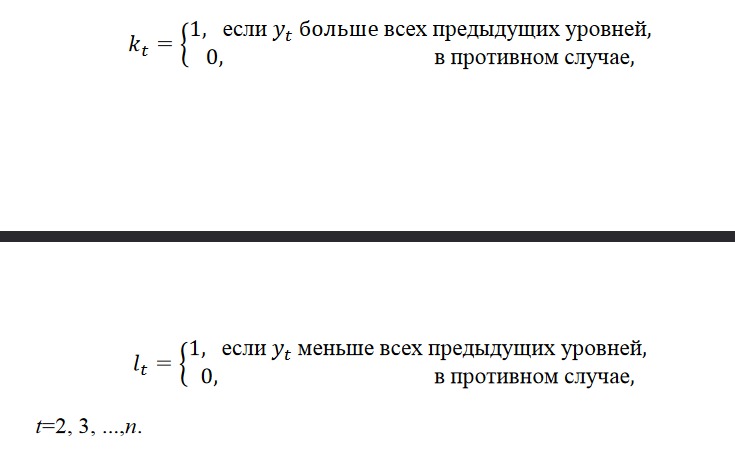

In [15]:
image = Image.open(BytesIO(first['images'][0]['bytes']))
display(image)

In [ ]:
first['conversation']

In [ ]:
# def encode_categories(example):
#     mapping = {
#         'captioning': 0,
#         'code': 1,
#         'creative_writing': 2,
#         'diagram': 3,
#         'entity_recognition': 4,
#         'homework': 5,
#         'humor': 6,
#         'is_code': 7,
#         'ocr': 8,
#         'refusal': 9
#     }
#     ids = [mapping[cat] for cat, val in example["categories"].items() if val]
#     return {"category_ids": ids}

# dataset = dataset[10].map(encode_categories)

In [ ]:
# type(dataset[:10])

### Send API request to Test

### Load the Image

In [ ]:
text_data= first['conversation'][0][0]['content']
text_data

In [ ]:
image_data = first['images'][0]['bytes']
if isinstance(image_data, list):                     # some HF datasets store ints
    image_data = bytes(image_data)
img_b64 = base64.b64encode(image_data).decode("utf-8")

### Prompt -1

In [ ]:
# Build multimodal message
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": text_data},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
        ]
    }
]

In [ ]:

# Measure latency
t0 = time.perf_counter()
resp = eval_client.chat.completions.create(
    model=EVAL_MODEL,
    messages=messages,
    max_tokens=128,
    temperature=0.0,
)
latency = time.perf_counter() - t0

print("=== Response ===")
ai_answer = resp.choices[0].message.content
print(resp.choices[0].message.content)
print(f"\nLatency: {latency:.3f} seconds")

In [ ]:
original_answer = first['conversation'][1][0]['content']
original_answer

In [ ]:
first['model']

### Evaluate - the answers

In [ ]:
JUDGE_PROMPT = r"""
You are a strict multimodal judge. You will be given:
- A USER_QUESTION
- An IMAGE
- A REFERENCE_ANSWER (original answer)
- A MODEL_ANSWER (answer to evaluate)

Step 1: Verify the REFERENCE_ANSWER against USER_QUESTION and IMAGE. Assume it is the baseline to match, unless it is clearly wrong.
Step 2: Judge MODEL_ANSWER against USER_QUESTION, IMAGE, and REFERENCE_ANSWER for:
  1. Correctness – Are facts consistent with the IMAGE and USER_QUESTION? Avoid contradictions.
  2. Completeness – Does it cover the important details present in REFERENCE_ANSWER?
  3. Relevance – Does it avoid adding off-topic or unsupported details not visible in IMAGE?

Scoring (0–100):
- Compute a weighted score:
  • Correctness: 0.40
  • Completeness: 0.45
  • Relevance: 0.15
- Start each sub-score at 1.0, subtract for errors, missing content, or irrelevant details.
- Final score = weighted sum × 100 (rounded to int).
- Cap at 99 if MODEL_ANSWER is missing facts or contains contradictions.
- Bonus: If MODEL_ANSWER adds new correct and IMAGE-supported details (not in REFERENCE_ANSWER), allow up to +3 points, capped at 100.
- If MODEL_ANSWER is empty, irrelevant, or a refusal → score 0–10.

Output:
Respond ONLY with JSON exactly like:
{"score": <int>, "justification": "<one short sentence>"}
"""


In [ ]:
def build_messages(user_question: str, reference: str, model_answer: str, img_b64: str):
    return [
        {"role": "system", "content": JUDGE_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    f"USER_QUESTION:\n{user_question}\n\n"
                    f"REFERENCE_ANSWER:\n{reference}\n\n"
                    f"MODEL_ANSWER:\n{model_answer}\n\n"
                    "Judge MODEL_ANSWER for correctness, completeness, and relevance relative to REFERENCE_ANSWER, USER_QUESTION, and IMAGE."
                )},
                {"type": "image_url",
                 "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
            ]
        }
    ]


In [ ]:
def run_judge(messages, max_retries=3):
    last_err = None
    for i in range(max_retries):
        try:
            resp = judge_client.chat.completions.create(
                model=JUDGE_MODEL,
                messages=messages,
                temperature=0,
                top_p=1,
                max_tokens=128,
                response_format={"type": "json_object"},
            )
            return json.loads(resp.choices[0].message.content)
        except Exception as e:
            last_err = e
            time.sleep(0.5*(i+1))
    raise RuntimeError(f"Judge failed: {last_err}")

In [ ]:
msgs = build_messages(text_data, original_answer, ai_answer, img_b64)
result = run_judge(msgs)
print(result)  # {"score": ..., "justification": "..."}